In [1]:
# Data and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, tree, datasets
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as sch
from scipy.stats import randint

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D, BatchNormalization, Flatten, MaxPooling1D, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# SciKeras
from scikeras.wrappers import KerasClassifier

# Other
import operator
from numpy import argmax
from math import floor
import time
from bayes_opt import BayesianOptimization

from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn import datasets  

In [2]:
weather = pd.read_csv(r"C:\Users\user\OneDrive\Documents\Data Analysis Course\Machine Learning\Climate Wins\2. Data Sets\weather_cleaned_filled.csv")
answers = pd.read_csv(r"C:\Users\user\OneDrive\Documents\Data Analysis Course\Machine Learning\Climate Wins\2. Data Sets\Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv")

In [3]:
weather = weather.drop(columns=[c for c in ["DATE","MONTH"] if c in weather.columns], errors="ignore")
answers = answers.drop(columns=["DATE"], errors="ignore")

** CNN MODEL

Reason: 

-excellent at finding spatial/local patterns 

-can handle structured tabular input reshaped into grids 

-training is faster and more stable than RNNs

CNN was chosen due to their efficiency at capturing local temporal patterns across multiple time steps, making them suitable for fixed-window weather sequence analysis.

In [4]:
tf.random.set_seed(42)

In [5]:
X=weather
y=answers

In [6]:
class_day = {
    0: 'UNPLEASANT',
    1: 'PLEASANT',
   
}

In [7]:
observations = [
    "cloud_cover", "global_radiation", "humidity", "precipitation",
    "pressure", "sunshine", "temp_max", "temp_mean", "temp_min"
]

In [8]:
# Create a copy of weather to avoid modifying original
weather_avg = pd.DataFrame()

for obs in observations:
    # Get all columns ending with the observation name
    cols = [col for col in weather.columns if col.endswith(obs)]
    weather_avg[obs] = weather[cols].mean(axis=1)


In [9]:
# Take the majority vote across all stations for each day
answers_binary = answers.apply(lambda col: col.map({'PLEASANT': 1, 'UNPLEASANT': 0}))
answers_binary['SONNBLICK_pleasant_weather'] = 0 #no pleasant weather recorded
y_raw = answers_binary.to_numpy()

In [10]:
def build_sequences(X_raw, y_raw, window_size=15):
  
    X_seq, y_seq = [], []

    for i in range(len(X_raw) - window_size + 1):
        # Features: 15-day window of observations
        X_window = X_raw[i:i + window_size]  # shape: (15, 9)

        # Labels: 15-day window across 15 stations → take majority vote per day
        y_window = y_raw[i:i + window_size]  # shape: (15, 15)
        y_majority = (np.mean(y_window, axis=1) > 0.5).astype(int)  # shape: (15,)

        # One-hot encode each day's label
        y_oh = np.eye(2)[y_majority]  # shape: (15, 2)

        # Append to sequences
        X_seq.append(X_window)
        y_seq.append(y_oh)

    return np.array(X_seq), np.array(y_seq)


In [11]:
# Extract NumPy arrays
X_raw = weather_avg.to_numpy()       # (22950, 9)
y_raw = answers_binary.to_numpy()  # (22950, 15)

# Build final sequences
X_seq, y_seq = build_sequences(X_raw, y_raw, window_size=15)

In [12]:
print("X_seq shape:", X_seq.shape)  # (22936, 15, 9)
print("y_seq shape:", y_seq.shape)  # (22936, 15, 2)

X_seq shape: (22936, 15, 9)
y_seq shape: (22936, 15, 2)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18348, 15, 9) (18348, 15, 2)
(4588, 15, 9) (4588, 15, 2)


In [15]:
print(X_train.shape, y_train.shape)

(18348, 15, 9) (18348, 15, 2)


In [16]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, InputLayer
from tensorflow.keras.layers import TimeDistributed

epochs = 30
batch_size = 16
n_hidden = 32

timesteps = 15
input_dim = 9
n_classes = 2

model = Sequential()
model.add(InputLayer(shape=(timesteps, input_dim)))
model.add(Conv1D(n_hidden, kernel_size=3, activation='relu', padding='same'))
model.add(TimeDistributed(Dense(16, activation='relu')))
model.add(TimeDistributed(Dense(n_classes, activation='softmax')))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(X_train,y_train, batch_size=16, epochs=30, verbose=2)

Epoch 1/30
1147/1147 - 5s - 5ms/step - accuracy: 0.9821 - loss: 0.1264
Epoch 2/30
1147/1147 - 3s - 2ms/step - accuracy: 1.0000 - loss: 8.8518e-06
Epoch 3/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 3.9877e-06
Epoch 4/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.8916e-06
Epoch 5/30
1147/1147 - 3s - 2ms/step - accuracy: 1.0000 - loss: 9.3631e-07
Epoch 6/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 4.8823e-07
Epoch 7/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 2.7925e-07
Epoch 8/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.8540e-07
Epoch 9/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.4622e-07
Epoch 10/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.3061e-07
Epoch 11/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.2414e-07
Epoch 12/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.2137e-07
Epoch 13/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.2016e-07
Epoch 14/30
1147/1147 - 2

In [19]:
def confusion_matrix(Y_true, Y_pred):
    class_day = {0: 'UNPLEASANT', 1: 'PLEASANT'}
    y_true_labels = [class_day[y] for y in np.argmax(Y_true, axis=-1).flatten()]
    y_pred_labels = [class_day[y] for y in np.argmax(Y_pred, axis=-1).flatten()]
    return pd.crosstab(pd.Series(y_true_labels, name="Actual"),
                       pd.Series(y_pred_labels, name="Predicted"))

In [20]:
# Evaluate
print(confusion_matrix(y_test, model.predict(X_test)))

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicted   UNPLEASANT
Actual                
UNPLEASANT       68820


In [21]:
# Just for class count check (does NOT modify original y_train/y_test)
y_train_flat = np.argmax(y_train, axis=-1).flatten()
y_test_flat = np.argmax(y_test, axis=-1).flatten()

print("Train class distribution:")
print(pd.Series(y_train_flat).value_counts())

print("\nTest class distribution:")
print(pd.Series(y_test_flat).value_counts())


Train class distribution:
0    275220
Name: count, dtype: int64

Test class distribution:
0    68820
Name: count, dtype: int64


In [22]:
print(answers.apply(pd.Series.value_counts))

   BASEL_pleasant_weather  BELGRADE_pleasant_weather  \
0                   17286                      14958   
1                    5664                       7992   

   BUDAPEST_pleasant_weather  DEBILT_pleasant_weather  \
0                      15519                    18491   
1                       7431                     4459   

   DUSSELDORF_pleasant_weather  HEATHROW_pleasant_weather  \
0                        18016                      17991   
1                         4934                       4959   

   KASSEL_pleasant_weather  LJUBLJANA_pleasant_weather  \
0                    19176                       16574   
1                     3774                        6376   

   MAASTRICHT_pleasant_weather  MADRID_pleasant_weather  \
0                        18184                    12703   
1                         4766                    10247   

   MUNCHENB_pleasant_weather  OSLO_pleasant_weather  \
0                      18183                  19371   
1           

In [23]:
epochs = 30
batch_size = 16
n_hidden = 64

timesteps = 15
input_dim = 9
n_classes = 2

mode = Sequential()
mode.add(InputLayer(shape=(timesteps, input_dim)))
mode.add(Conv1D(n_hidden, kernel_size=3, activation='relu', padding='same'))
mode.add(TimeDistributed(Dense(16, activation='relu')))
mode.add(TimeDistributed(Dense(n_classes, activation='softmax')))

In [24]:
mode.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
mode.fit(X_train,y_train, batch_size=16, epochs=30, verbose=2)

Epoch 1/30
1147/1147 - 4s - 3ms/step - accuracy: 0.9999 - loss: 5.1652e-04
Epoch 2/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 2.5859e-07
Epoch 3/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.5843e-07
Epoch 4/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.3467e-07
Epoch 5/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.2593e-07
Epoch 6/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.2217e-07
Epoch 7/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.2053e-07
Epoch 8/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.1980e-07
Epoch 9/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.1949e-07
Epoch 10/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.1934e-07
Epoch 11/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.1927e-07
Epoch 12/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.1925e-07
Epoch 13/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.1923e-07
Epoch 14/30
1147/1147

In [26]:
# Evaluate
print(confusion_matrix(y_test, mode.predict(X_test)))

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicted   UNPLEASANT
Actual                
UNPLEASANT       68820


In [27]:
epochs = 30
batch_size = 16
n_hidden = 2

timesteps = 15
input_dim = 9
n_classes = 2

mod = Sequential()
mod.add(InputLayer(shape=(timesteps, input_dim)))
mod.add(Conv1D(n_hidden, kernel_size=3, activation='relu', padding='same'))
mod.add(TimeDistributed(Dense(16, activation='relu')))
mod.add(TimeDistributed(Dense(n_classes, activation='softmax')))

In [28]:
mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
mod.fit(X_train,y_train, batch_size=16, epochs=30, verbose=2)

Epoch 1/30
1147/1147 - 4s - 3ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 2/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 2.9773e-05
Epoch 3/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 7.1894e-06
Epoch 4/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 2.6291e-06
Epoch 5/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.1645e-06
Epoch 6/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 5.9045e-07
Epoch 7/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 3.4073e-07
Epoch 8/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 2.2561e-07
Epoch 9/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.7075e-07
Epoch 10/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.4414e-07
Epoch 11/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.3111e-07
Epoch 12/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.2479e-07
Epoch 13/30
1147/1147 - 2s - 2ms/step - accuracy: 1.0000 - loss: 1.2176e-07
Epoch 14/30
1147/1147 - 2

In [30]:
# Evaluate
print(confusion_matrix(y_test, mod.predict(X_test)))

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicted   UNPLEASANT
Actual                
UNPLEASANT       68820


## Bayesian

In [31]:
from sklearn.utils.multiclass import type_of_target
print(type_of_target(y))  # should return 'binary'

multilabel-indicator


In [32]:
# Convert one-hot / multilabel-indicator to single integer labels
# integer indices
y = np.argmax(y.to_numpy(), axis=1)

In [33]:
print(type_of_target(y))

multiclass


In [34]:
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)

In [35]:
def train_model(conv1d_filters, kernel_size, dropout_rate):
    conv1d_filters = int(conv1d_filters)
    kernel_size = int(kernel_size)
    
    model = Sequential()
    model.add(Conv1D(filters=conv1d_filters, kernel_size=kernel_size, activation='relu', input_shape=(15, 9)))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(15, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)
    score = model.evaluate(X_test, y_test, verbose=0)
    
    return score[1]  # Return accuracy


In [36]:
pbounds = {
    'conv1d_filters': (8, 64),
    'kernel_size': (2, 5),
    'dropout_rate': (0.1, 0.5),
}

optimizer = BayesianOptimization(f=train_model, pbounds=pbounds, verbose=2, random_state=42)
optimizer.maximize(init_points=3, n_iter=5)


|   iter    |  target   | conv1d... | kernel... | dropou... |
-------------------------------------------------------------
| 1         | 0.0047951 | 28.974246 | 4.8521429 | 0.3927975 |
| 2         | 0.0263731 | 41.524875 | 2.4680559 | 0.1623978 |
| 3         | 0.0       | 11.252682 | 4.5985284 | 0.3404460 |
| 4         | 0.0002179 | 18.182198 | 3.5096282 | 0.2367943 |
| 5         | 0.0100261 | 40.604735 | 2.7121759 | 0.1399501 |
| 6         | 0.0006538 | 41.630942 | 2.0583746 | 0.1262951 |
| 7         | 0.0       | 33.482613 | 2.6400227 | 0.1814485 |
| 8         | 0.0065387 | 46.757411 | 3.1412481 | 0.3736554 |


In [37]:
best_params = optimizer.max['params']
conv1d_filters = int(best_params['conv1d_filters'])
kernel_size = int(best_params['kernel_size'])
dropout_rate = best_params['dropout_rate']

model = Sequential()
model.add(Conv1D(filters=conv1d_filters, kernel_size=kernel_size, activation='relu', input_shape=(15, 9)))
model.add(Flatten())
model.add(Dropout(dropout_rate))
model.add(Dense(15, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

Epoch 1/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0583 - loss: 0.1115
Epoch 2/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0765 - loss: 2.8644e-05
Epoch 3/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0679 - loss: 7.6116e-06
Epoch 4/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0594 - loss: 3.5014e-06
Epoch 5/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0620 - loss: 1.9398e-06
Epoch 6/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0590 - loss: 1.2281e-06
Epoch 7/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0583 - loss: 8.2452e-07
Epoch 8/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0562 - loss: 6.2012e-07
Epoch 9/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0538 - loss: 4.4642e-07
Epoch 10/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0527 - loss: 3.3779e-07
Epoch 11/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0540 - loss: 2.6642e-07
Epoch 12/30


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           0       1.00      0.01      0.02      4588
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0

    accuracy                           0.01      4588
   macro avg       0.08      0.00      0.00      4588
weighted avg       1.00      0.01      0.02      4588



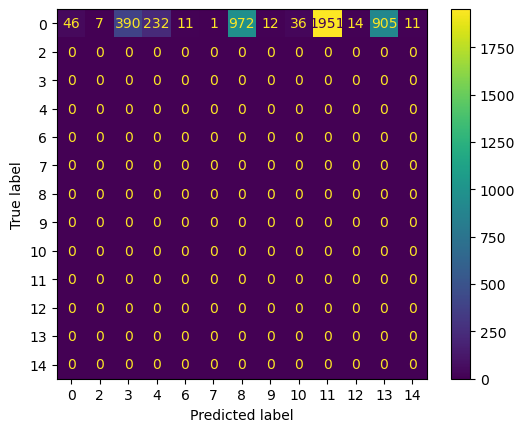

In [39]:
y_pred = model.predict(X_test)

y_test_single = argmax(y_test, axis=1)
y_pred_single = argmax(y_pred, axis=1)

print(classification_report(y_test_single, y_pred_single))
ConfusionMatrixDisplay.from_predictions(y_test_single, y_pred_single)
plt.show()

The Baysian model failed to outperform the CNN model. While the CNN model achieved near-perfect training accuracy (100%) and an extremely low loss value, the optimized version plateaued at approximately 5.8% accuracy, despite the continued decrease in loss. This drastic decline indicates severe underfitting, where the model fails to capture patterns in the training data. The very low accuracy, paired with diminishing loss, confirms that the optimization process unintentionally degraded performance. As a result, the CNN model remains more effective.